**Подключение библиотек и скриптов**

In [1]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.metrics import mean_squared_error

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

In [2]:
matplotlib.rcParams.update({'font.size': 12})  # размер шрифта на графиках

**Пути к директориям и файлам**

In [3]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

PREPARED_DATASET_PATH = './course_prepared.csv'
PREDICTIONS_PATH = './EVarlamov_predictions.csv'

### Загрузка данных

**Описание датасета:**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Room** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [4]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)

train_df.shape

(10000, 20)

In [5]:
test_df = pd.read_csv(TEST_DATASET_PATH)

test_df.shape

(5000, 19)

In [6]:
df = pd.concat([train_df, test_df], axis=0)

In [7]:
df.shape

(15000, 20)

In [8]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [9]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             15000 non-null  int64  
 1   DistrictId     15000 non-null  int64  
 2   Rooms          15000 non-null  float64
 3   Square         15000 non-null  float64
 4   LifeSquare     11846 non-null  float64
 5   KitchenSquare  15000 non-null  float64
 6   Floor          15000 non-null  int64  
 7   HouseFloor     15000 non-null  float64
 8   HouseYear      15000 non-null  int64  
 9   Ecology_1      15000 non-null  float64
 10  Ecology_2      15000 non-null  object 
 11  Ecology_3      15000 non-null  object 
 12  Social_1       15000 non-null  int64  
 13  Social_2       15000 non-null  int64  
 14  Social_3       15000 non-null  int64  
 15  Healthcare_1   7825 non-null   float64
 16  Helthcare_2    15000 non-null  int64  
 17  Shops_1        15000 non-null  int64  
 18  Shops_2

**Уменьшение объема памяти, который занимает датасет**

In [10]:
df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [11]:
df['Id'] = df['Id'].astype(str)

In [12]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [13]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 2.40 MB
Memory usage after optimization is: 1.46 MB
Decreased by 39.1%


In [14]:
df.dtypes

Id               category
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

# 1. Распределение целевой переменной

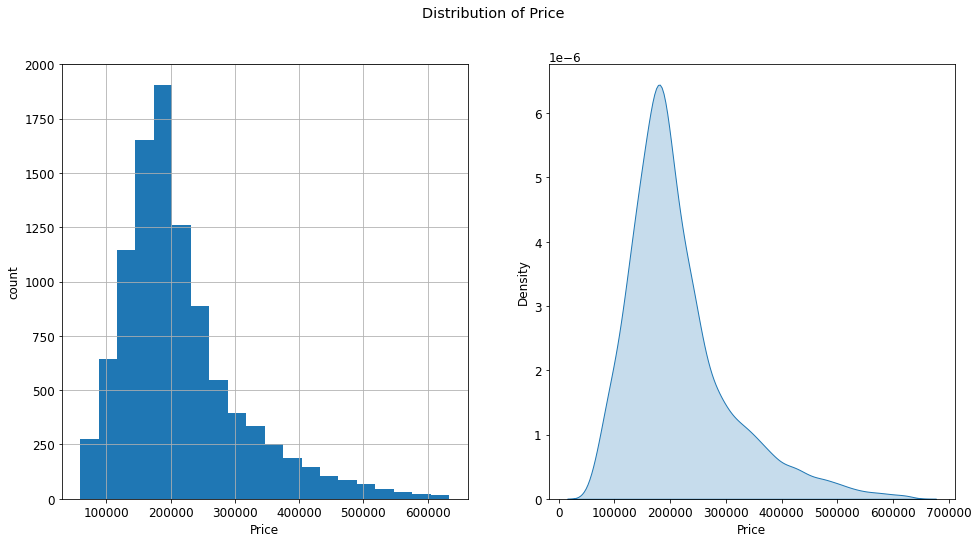

In [15]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
df['Price'].hist(density=False, bins=20)
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(df['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of Price')
plt.show()

In [16]:
target = df['Price']
target_mean = round(df['Price'].mean(), 2)
target_median = df['Price'].median()
target_mode = df['Price'].mode()[0]
target_mode

182938.08

In [17]:
target.value_counts()

298194.500000    2
204576.421875    2
182938.078125    2
238608.656250    2
200309.000000    1
                ..
148657.625000    1
191668.406250    1
566435.125000    1
96245.515625     1
559215.437500    1
Name: Price, Length: 9996, dtype: int64

In [18]:
target.min()

59174.777

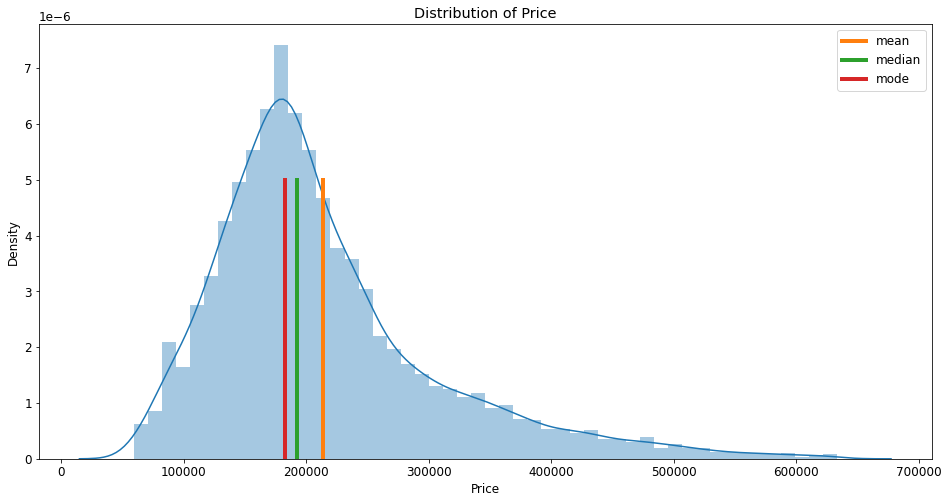

In [19]:
plt.figure(figsize = (16, 8))

sns.distplot(df['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean',  linewidth=4)
plt.plot([target_median] * 10, y, label='median',  linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

# 2. Анализ признаков

### 2.1 Количественные признаки

In [20]:
df.describe(percentiles=[
    p for p in np.arange(0, 1, 0.1)
])

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,15000.000000,15000.000000,15000.000000,11846.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,7825.000000,15000.000000,15000.000000,10000.000000
mean,50.693600,1.897000,56.360352,36.851791,6.174467,8.561800,12.606600,3.321575e+03,0.119196,24.769267,5370.404933,8.113667,1144.162476,1.319467,4.235133,214138.859375
std,43.786257,0.839229,20.423912,71.120186,24.016979,5.323113,6.780165,1.637078e+05,0.119371,17.532278,4013.364403,23.841946,1029.296265,1.489012,4.796545,92872.289062
min,0.000000,0.000000,1.136859,0.333490,0.000000,1.000000,0.000000,1.908000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
0%,0.000000,0.000000,1.136859,0.333490,0.000000,1.000000,0.000000,1.908000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
10%,6.000000,1.000000,36.969182,19.605579,1.000000,3.000000,4.000000,1.965000e+03,0.000991,2.000000,475.000000,0.000000,125.000000,0.000000,0.000000,118846.148438
20%,11.000000,1.000000,40.407307,21.868359,1.000000,4.000000,5.000000,1.971000e+03,0.007720,5.000000,1437.000000,0.000000,240.000000,0.000000,0.000000,144036.093750
30%,23.000000,1.000000,43.230053,24.593927,1.000000,5.000000,9.000000,1.977000e+03,0.034656,11.000000,2738.000000,1.000000,540.000000,0.000000,1.000000,162618.875000
40%,27.000000,2.000000,46.931654,30.199327,5.000000,6.000000,12.000000,1.977000e+03,0.050756,22.000000,4439.000000,1.000000,645.000000,0.000000,2.000000,178426.859375
50%,37.000000,2.000000,52.645758,32.822811,6.000000,7.000000,12.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.656250


In [21]:
df_num_features = df.select_dtypes(include=['float32', 'int8', 'int16', 'int32'])
df_num_features.drop('Price', axis=1, inplace=True)
#df_num_features.drop('Id', axis=1, inplace=True)
df_num_features

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
0,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,NaN,0,11
1,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16
2,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3
3,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,23,5735,3,1084.0,0,5
4,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,35,5776,1,2078.0,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,11,3.0,67.133911,50.809795,6.0,5,9.0,1973,0.000170,36,5992,0,NaN,1,1
4996,1,1.0,40.198471,21.807060,10.0,12,17.0,2017,0.007122,1,264,0,NaN,0,1
4997,12,3.0,77.842178,48.282623,9.0,23,22.0,1989,0.090799,74,19083,2,NaN,5,15
4998,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,2,629,1,NaN,0,0


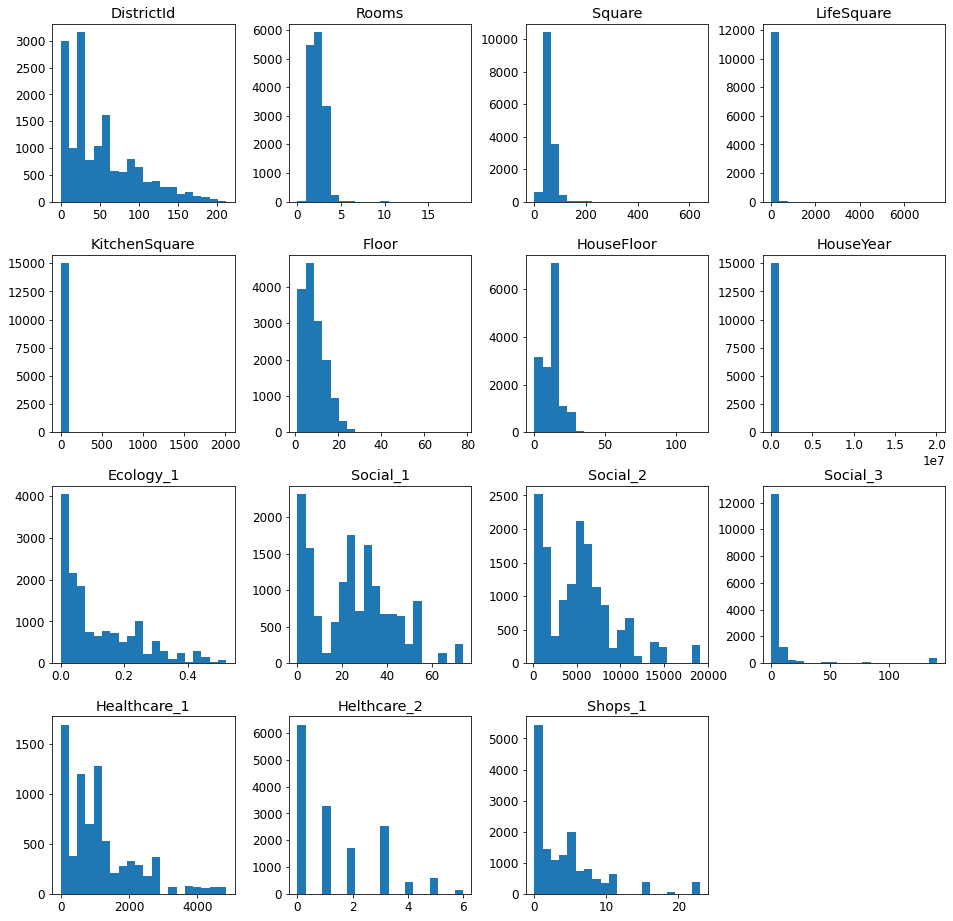

In [22]:
df_num_features.hist(figsize=(16, 16), bins=20, grid=False);

**По распределению целевой переменной видим лог-нормальное ее распределение. Выбросов нет. Имеются пробелы/незаполненные признаки: LifeSquare, Healthcare_1. По признакам. Rooms: 0 комнат в квартире, нужно будет отбратить внимание. Square: квартиры с площадью около 0м2. LifeSquare: превышает значение общей площади. KitchenSquare: имеется площадь 0 и больше общей площади квартиры. Обратить внимание на этажность домов. Убрать выбросы, заменить данные у признаков: KitchenSquare, HouseYear, LifeSquare, Square, Social_3, Shops_1**

In [23]:
kitchen_bins = df['KitchenSquare']
kitchen_bins.value_counts().iloc[:10]

1.0     3651
8.0     1912
5.0     1781
6.0     1633
10.0    1633
9.0     1260
0.0     1032
7.0      906
12.0     381
11.0     340
Name: KitchenSquare, dtype: int64

In [24]:
kitchen_bins[kitchen_bins > 20].value_counts().iloc[:10]

22.0     4
42.0     4
112.0    3
30.0     3
41.0     3
32.0     2
58.0     2
62.0     2
37.0     2
25.0     2
Name: KitchenSquare, dtype: int64

In [25]:
year_bins = df['HouseYear']
year_bins[year_bins > 2021].value_counts().iloc[:10]

4968        1
20052011    1
Name: HouseYear, dtype: int64

**Поиск выбросов с помощью box plot**

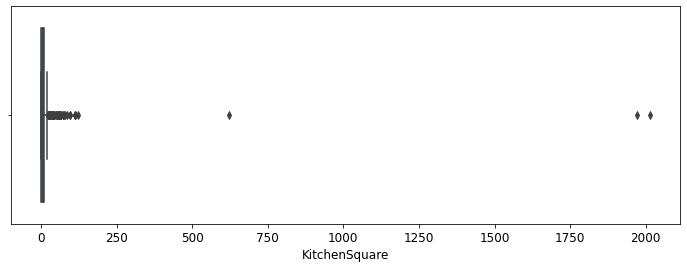

In [26]:
plt.figure(figsize=(12, 4))

sns.boxplot(df['KitchenSquare'], whis=1.5)

plt.xlabel('KitchenSquare')
plt.show()

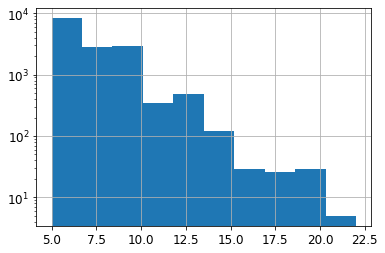

In [27]:
df.loc[df['KitchenSquare'] > 22, 'KitchenSquare'] = df['KitchenSquare'].median()
df.loc[df['KitchenSquare'] < 5, 'KitchenSquare'] = df['KitchenSquare'].median()

df['KitchenSquare'].hist()
plt.yscale('log')

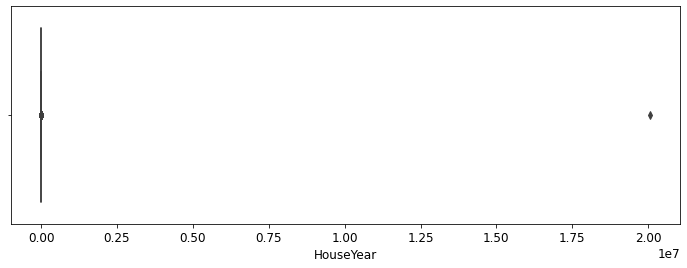

In [28]:
plt.figure(figsize=(12, 4))

sns.boxplot(df['HouseYear'], whis=1.5)

plt.xlabel('HouseYear')
plt.show()

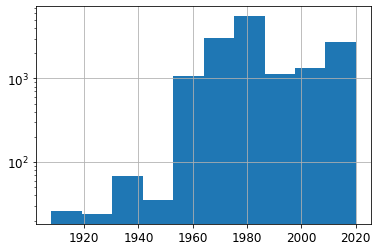

In [29]:
df.loc[df['HouseYear'] > 2021, 'HouseYear'] = df['HouseYear'].median()
df['HouseYear'].hist()
plt.yscale('log')

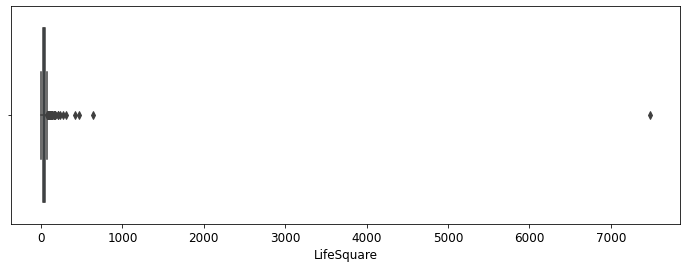

In [30]:
plt.figure(figsize=(12, 4))

sns.boxplot(df['LifeSquare'], whis=1.5)

plt.xlabel('LifeSquare')
plt.show()

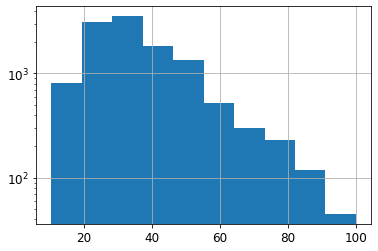

In [31]:
df.loc[df['LifeSquare'] > 100, 'LifeSquare'] = df['LifeSquare'].median()
df.loc[df['LifeSquare'] < 10, 'LifeSquare'] = df['LifeSquare'].median()

df['LifeSquare'].hist()
plt.yscale('log')

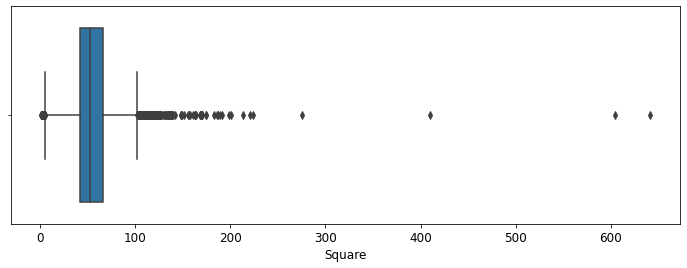

In [32]:
plt.figure(figsize=(12, 4))

sns.boxplot(df['Square'], whis=1.5)

plt.xlabel('Square')
plt.show()

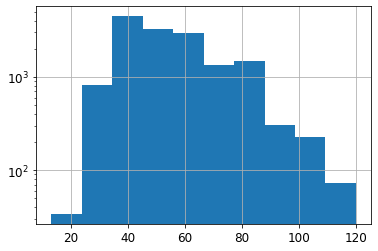

In [33]:
df.loc[df['Square'] > 120, 'Square'] = df['Square'].median()
df.loc[df['Square'] < 7, 'Square'] = df['Square'].median()

df['Square'].hist()
plt.yscale('log')

In [34]:
df['Square'].value_counts().iloc[:10]

52.645760    133
52.644936     20
65.285133      2
81.867165      2
37.498161      2
65.344337      2
39.145321      2
44.482914      2
35.091915      2
66.793839      2
Name: Square, dtype: int64

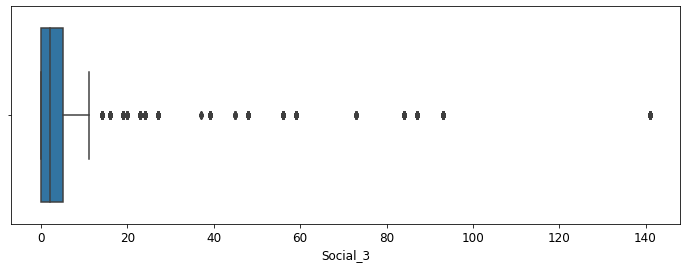

In [35]:
plt.figure(figsize=(12, 4))

sns.boxplot(df['Social_3'], whis=1.5)

plt.xlabel('Social_3')
plt.show()

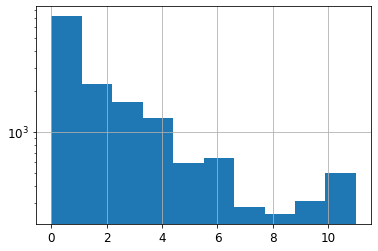

In [36]:
df.loc[df['Social_3'] > 12, 'Social_3'] = df['Social_3'].median()
df['Social_3'].hist()
plt.yscale('log')

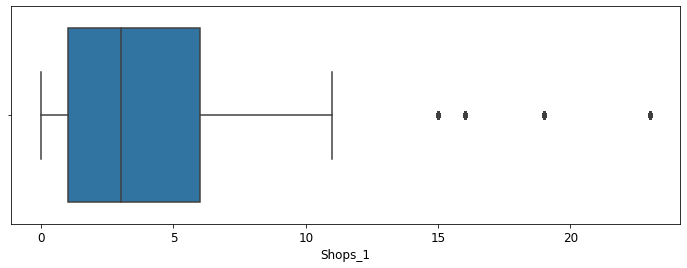

In [37]:
plt.figure(figsize=(12, 4))

sns.boxplot(df['Shops_1'], whis=1.5)

plt.xlabel('Shops_1')
plt.show()

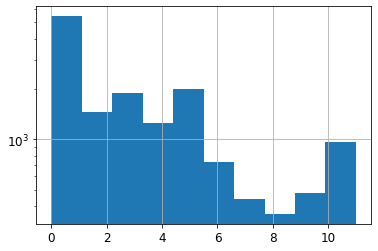

In [38]:
df.loc[df['Shops_1'] > 11, 'Shops_1'] = df['Shops_1'].median()
df['Shops_1'].hist()
plt.yscale('log')

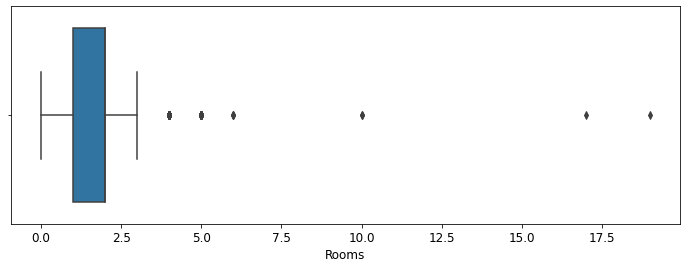

In [39]:
plt.figure(figsize=(12, 4))

sns.boxplot(df['Rooms'], whis=1.5)

plt.xlabel('Rooms')
plt.show()

### 2.2 Категориальные признаки

In [40]:
cat_colnames = df.select_dtypes(include='category').columns.tolist()
cat_colnames

['Id', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [41]:
for cat_colname in cat_colnames:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Id

0        1
4946     1
4933     1
4934     1
4935     1
        ..
15041    1
15042    1
15043    1
15045    1
9999     1
Name: Id, Length: 15000, dtype: int64
****************************************************************************************************

Ecology_2

B    14855
A      145
Name: Ecology_2, dtype: int64
****************************************************************************************************

Ecology_3

B    14576
A      424
Name: Ecology_3, dtype: int64
****************************************************************************************************

Shops_2

B    13763
A     1237
Name: Shops_2, dtype: int64
****************************************************************************************************



### 2.3 Бинарные признаки

In [42]:
df['Ecology_2_bin'] = df['Ecology_2'].replace({'A':0, 'B':1})
df['Ecology_3_bin'] = df['Ecology_3'].replace({'A':0, 'B':1})
df['Shops_2_bin'] = df['Shops_2'].replace({'A':0, 'B':1})

### 2.4 Матрица корреляций

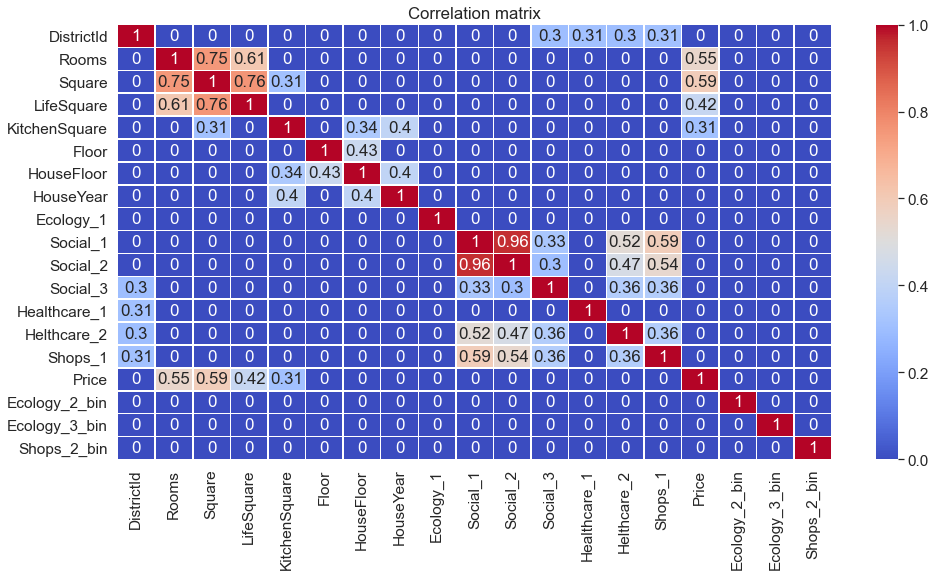

In [43]:
plt.figure(figsize = (16,8))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

**На матрице корреляций не видно зависимости между этажностью/этажом и ценой**

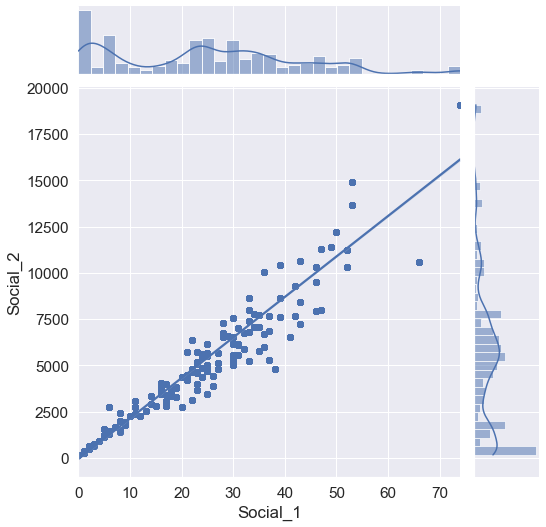

In [44]:
grid = sns.jointplot(df['Social_1'], df['Social_2'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

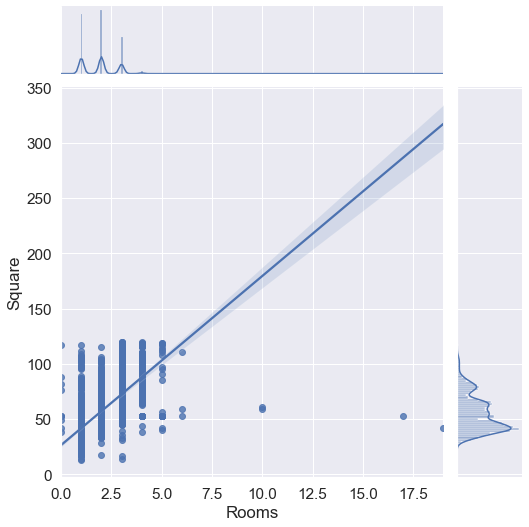

In [45]:
grid = sns.jointplot(df['Rooms'], df['Square'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

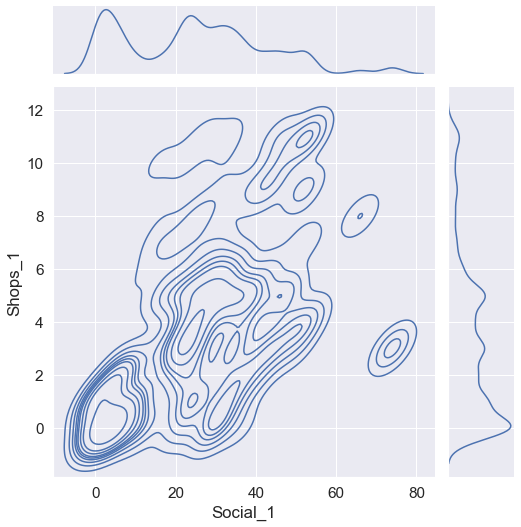

In [46]:
grid = sns.jointplot(df['Social_1'], df['Shops_1'], kind='kde')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

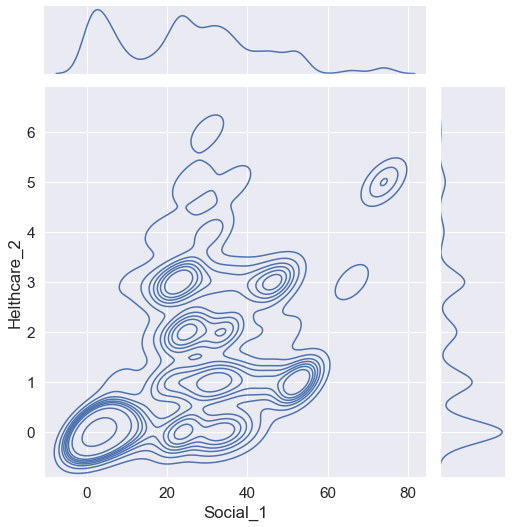

In [47]:
grid = sns.jointplot(df['Social_1'], df['Helthcare_2'], kind='kde')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

In [48]:
#df_num_features_norm = df.select_dtypes(include=['float32', 'int8', 'int16', 'int32'])
#df_num_features_norm.drop('Price', axis=1, inplace=True)
#df_num_features_norm.drop('Id', axis=1, inplace=True)
#df_num_features_norm.hist(figsize=(16, 16), bins=20, grid=False);

# 3. Анализ зависимости таргета от фичей

## 3.1 Количественные признаки

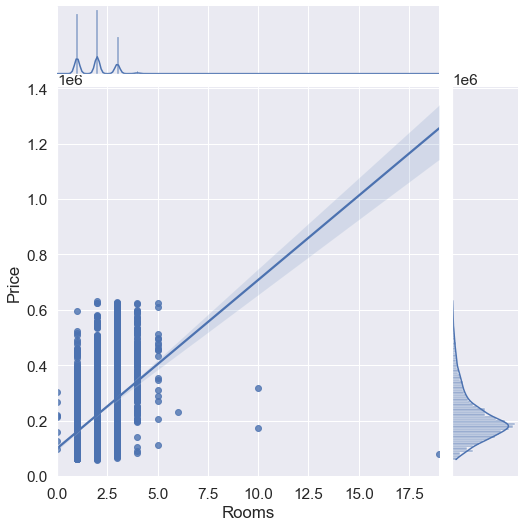

In [49]:
grid = sns.jointplot(df['Rooms'], df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

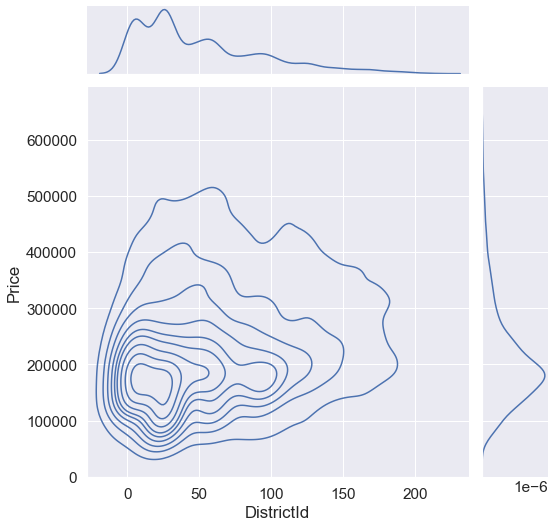

In [50]:
grid = sns.jointplot(df['DistrictId'], df['Price'], kind='kde')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

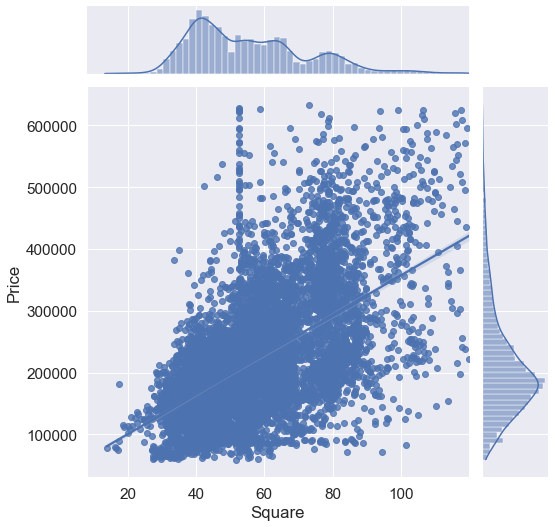

In [51]:
grid = sns.jointplot(df['Square'], df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

# 4. Очистка данных и Feature engineering

**Оставим признаки, которые необходимы для модели**

In [52]:
df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin']

In [53]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 
                 'HouseYear', 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3', 
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin']

target_name = 'Price'
df = df[feature_names + [target_name]]
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2_bin,Ecology_3_bin,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2_bin,Price
0,35,2.0,47.981560,29.442751,6.0,7,9.0,1969.0,0.089040,1,1,33,7976,5.0,NaN,0,11.0,1,184966.937500
1,41,3.0,65.683640,40.049541,8.0,7,9.0,1978.0,0.000070,1,1,46,10309,1.0,240.0,1,3.0,1,300009.437500
2,53,2.0,44.947952,29.197611,6.0,8,12.0,1968.0,0.049637,1,1,34,7759,0.0,229.0,1,3.0,1,220925.906250
3,58,2.0,53.352982,52.731510,9.0,8,17.0,1977.0,0.437885,1,1,23,5735,3.0,1084.0,0,5.0,1,175616.234375
4,99,1.0,39.649193,23.776169,7.0,11,12.0,1976.0,0.012339,1,1,35,5776,1.0,2078.0,2,4.0,1,150226.531250


### Обработка пропусков

In [54]:
df.isnull().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare       3154
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2_bin       0
Ecology_3_bin       0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     7175
Helthcare_2         0
Shops_1             0
Shops_2_bin         0
Price            5000
dtype: int64

**LifeSquare**

In [55]:
df['LifeSquare'].median()

32.822433

In [56]:
square_med_diff = (df.loc[df['LifeSquare'].notnull(), 'Square'] -\
                   df.loc[df['LifeSquare'].notnull(), 'LifeSquare'] -\
                   df.loc[df['LifeSquare'].notnull(), 'KitchenSquare']).median()

square_med_diff

11.312544

In [57]:
df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] =\
df.loc[df['LifeSquare'].isnull(), 'Square'] -\
df.loc[df['LifeSquare'].isnull(), 'KitchenSquare'] -\
square_med_diff

In [58]:
df['LifeSquare'].median()

33.426537

**Healthcare_1**

In [59]:
df['Healthcare_1'].value_counts()

540.0     768
30.0      511
1046.0    365
750.0     235
2300.0    220
         ... 
32.0       19
1815.0     19
920.0      19
35.0        4
0.0         2
Name: Healthcare_1, Length: 79, dtype: int64

In [60]:
df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()

### Построение новых признаков

In [61]:
med_square_by_flat = df.groupby(['Rooms'], as_index=False).agg({'Square':'median'})\
                     .rename(columns={'Square':'MedSquareByFlat'})
med_square_by_flat.head()

,Rooms,MedSquareByFlat
0,0.0,52.645760
1,1.0,40.354576
2,2.0,55.821732
3,3.0,77.073906
4,4.0,92.880951


In [62]:
df = df.merge(med_square_by_flat, on='Rooms', how='left')
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2_bin,Ecology_3_bin,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2_bin,Price,MedSquareByFlat
0,35,2.0,47.981560,29.442751,6.0,7,9.0,1969.0,0.089040,1,1,33,7976,5.0,900.0,0,11.0,1,184966.937500,55.821732
1,41,3.0,65.683640,40.049541,8.0,7,9.0,1978.0,0.000070,1,1,46,10309,1.0,240.0,1,3.0,1,300009.437500,77.073906
2,53,2.0,44.947952,29.197611,6.0,8,12.0,1968.0,0.049637,1,1,34,7759,0.0,229.0,1,3.0,1,220925.906250,55.821732
3,58,2.0,53.352982,52.731510,9.0,8,17.0,1977.0,0.437885,1,1,23,5735,3.0,1084.0,0,5.0,1,175616.234375,55.821732
4,99,1.0,39.649193,23.776169,7.0,11,12.0,1976.0,0.012339,1,1,35,5776,1.0,2078.0,2,4.0,1,150226.531250,40.354576


In [63]:
df['meter_price'] = df['Price'] / df['Square']
df

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2_bin,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2_bin,Price,MedSquareByFlat,meter_price
0,35,2.0,47.981560,29.442751,6.0,7,9.0,1969.0,0.089040,1,...,33,7976,5.0,900.0,0,11.0,1,184966.937500,55.821732,3854.958740
1,41,3.0,65.683640,40.049541,8.0,7,9.0,1978.0,0.000070,1,...,46,10309,1.0,240.0,1,3.0,1,300009.437500,77.073906,4567.491211
2,53,2.0,44.947952,29.197611,6.0,8,12.0,1968.0,0.049637,1,...,34,7759,0.0,229.0,1,3.0,1,220925.906250,55.821732,4915.149414
3,58,2.0,53.352982,52.731510,9.0,8,17.0,1977.0,0.437885,1,...,23,5735,3.0,1084.0,0,5.0,1,175616.234375,55.821732,3291.591797
4,99,1.0,39.649193,23.776169,7.0,11,12.0,1976.0,0.012339,1,...,35,5776,1.0,2078.0,2,4.0,1,150226.531250,40.354576,3788.892578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,11,3.0,67.133911,50.809795,6.0,5,9.0,1973.0,0.000170,1,...,36,5992,0.0,900.0,1,1.0,1,NaN,77.073906,NaN
14996,1,1.0,40.198471,21.807060,10.0,12,17.0,2017.0,0.007122,1,...,1,264,0.0,900.0,0,1.0,1,NaN,40.354576,NaN
14997,12,3.0,77.842178,48.282623,9.0,23,22.0,1989.0,0.090799,1,...,74,19083,2.0,900.0,5,3.0,1,NaN,77.073906,NaN
14998,62,2.0,81.305222,63.992676,6.0,4,0.0,1977.0,0.072158,1,...,2,629,1.0,900.0,0,0.0,0,NaN,55.821732,NaN


In [64]:
med_meter_price_by_district = df.groupby(['DistrictId'], as_index=False).agg({'meter_price':'median'})\
                       .rename(columns={'meter_price':'MedMeterPrice'})

med_meter_price_by_district.head()

,DistrictId,MedMeterPrice
0,0,3935.906738
1,1,3252.330078
2,2,4550.708984
3,3,3913.575439
4,4,5716.888672


In [65]:
df = df.merge(med_meter_price_by_district, on='DistrictId', how='left')
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2_bin,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2_bin,Price,MedSquareByFlat,meter_price,MedMeterPrice
0,35,2.0,47.981560,29.442751,6.0,7,9.0,1969.0,0.089040,1,...,7976,5.0,900.0,0,11.0,1,184966.937500,55.821732,3854.958740,4358.274902
1,41,3.0,65.683640,40.049541,8.0,7,9.0,1978.0,0.000070,1,...,10309,1.0,240.0,1,3.0,1,300009.437500,77.073906,4567.491211,4437.304199
2,53,2.0,44.947952,29.197611,6.0,8,12.0,1968.0,0.049637,1,...,7759,0.0,229.0,1,3.0,1,220925.906250,55.821732,4915.149414,4845.918945
3,58,2.0,53.352982,52.731510,9.0,8,17.0,1977.0,0.437885,1,...,5735,3.0,1084.0,0,5.0,1,175616.234375,55.821732,3291.591797,2977.985840
4,99,1.0,39.649193,23.776169,7.0,11,12.0,1976.0,0.012339,1,...,5776,1.0,2078.0,2,4.0,1,150226.531250,40.354576,3788.892578,3992.031250


In [66]:
df.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8')

In [67]:
df = pd.read_csv(PREPARED_DATASET_PATH)

### Отбор признаков

In [68]:
df.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2_bin',
 'Price',
 'MedSquareByFlat',
 'meter_price',
 'MedMeterPrice']

In [69]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2',
 'Shops_1', 'Shops_2_bin', 'MedSquareByFlat', 'MedMeterPrice']

new_feature_names = ['MedSquareByFlat', 'MedMeterPrice']
target_name = 'Price'

# 5. Разбиение на train / test

In [70]:
test_df = df[df['Price'].isnull()]

test_df.shape

(5000, 22)

In [71]:
train_df = df[df['Price'].notnull()]

train_df.shape

(10000, 22)

In [72]:
X = train_df[feature_names]
y = train_df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [73]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 9069 to 7270
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DistrictId       7000 non-null   int64  
 1   Rooms            7000 non-null   float64
 2   Square           7000 non-null   float64
 3   LifeSquare       7000 non-null   float64
 4   KitchenSquare    7000 non-null   float64
 5   Floor            7000 non-null   int64  
 6   HouseFloor       7000 non-null   float64
 7   HouseYear        7000 non-null   float64
 8   Ecology_1        7000 non-null   float64
 9   Ecology_2_bin    7000 non-null   int64  
 10  Ecology_3_bin    7000 non-null   int64  
 11  Social_1         7000 non-null   int64  
 12  Social_2         7000 non-null   int64  
 13  Social_3         7000 non-null   float64
 14  Healthcare_1     7000 non-null   float64
 15  Helthcare_2      7000 non-null   int64  
 16  Shops_1          7000 non-null   float64
 17  Shops_2_bin

# 6. Построение модели

### Random Forest

In [74]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

In [75]:
clf = RandomForestRegressor(max_depth=7, max_features=8, n_estimators=1000)

clf.fit(X_train.values, y_train.values)

RandomForestRegressor(max_depth=7, max_features=8, n_estimators=1000)

R2:	0.797
RMSE:	41836.69
MSE:	1750308606.5


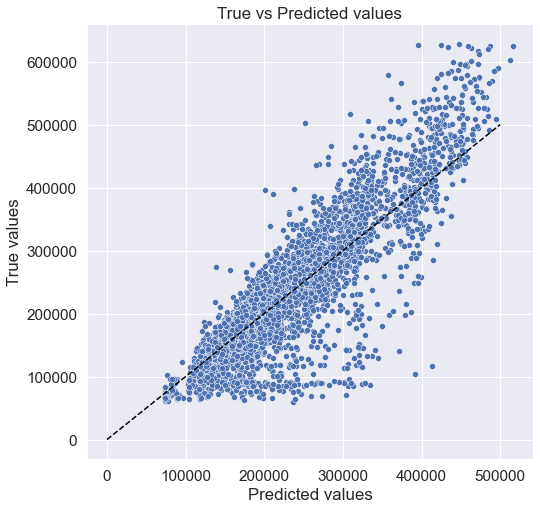

In [76]:
y_train_preds = clf.predict(X_train)

evaluate_preds(y_train, y_train_preds)

R2:	0.713
RMSE:	49647.493
MSE:	2464873534.107


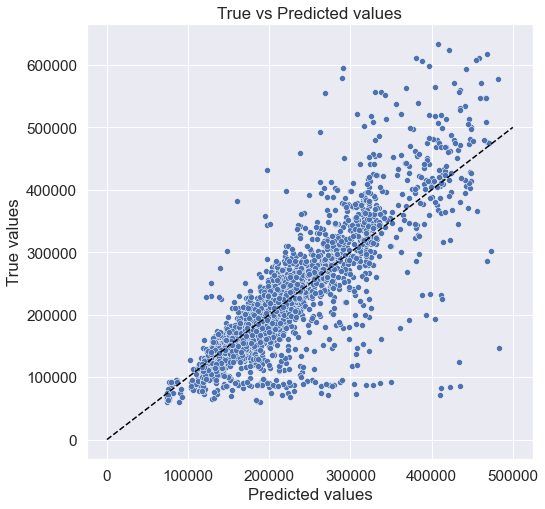

In [77]:
y_test_preds = clf.predict(X_test)

evaluate_preds(y_test, y_test_preds)

# 7. Анализ прогнозов 

**Важность признаков**

In [78]:
rf_importance = pd.DataFrame({
    "feature_name": X_train.columns,
    "feature_importance": clf.feature_importances_})

rf_importance = rf_importance.sort_values(
    by="feature_importance", ascending=False
)
rf_importance = rf_importance.reset_index(drop=True)
rf_importance.head(n=100)

,feature_name,feature_importance
0,MedMeterPrice,0.251887
1,Square,0.249227
2,MedSquareByFlat,0.128486
3,Rooms,0.109150
4,LifeSquare,0.048627
5,Social_2,0.048053
6,Social_1,0.039619
7,KitchenSquare,0.029899
8,HouseYear,0.015671
9,Social_3,0.014453


# 8. Предобработка test файла

In [79]:
test_df.drop('Price', axis=1, inplace=True)
test_df.drop('meter_price', axis=1, inplace=True)

test_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2_bin,Ecology_3_bin,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2_bin,MedSquareByFlat,MedMeterPrice
10000,58,2.0,49.882645,33.432780,6.0,6,14.0,1972.0,0.310199,1,1,11,2748,1.0,900.0,0,0.0,1,55.821730,2977.9858
10001,74,2.0,69.263180,51.950638,6.0,6,1.0,1977.0,0.075779,1,1,6,1437,3.0,900.0,0,2.0,1,55.821730,3347.5342
10002,190,1.0,13.597818,15.948246,12.0,2,5.0,1909.0,0.000000,1,1,30,7538,2.0,4702.0,5,5.0,1,40.354576,8645.1710
10003,47,2.0,73.046610,51.940840,9.0,22,22.0,2007.0,0.101872,1,1,23,4583,3.0,900.0,3,3.0,1,55.821730,4181.9640
10004,27,1.0,47.527110,43.387570,6.0,17,17.0,2017.0,0.072158,1,1,2,629,1.0,900.0,0,0.0,0,40.354576,2764.8438


In [80]:
test_df

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2_bin,Ecology_3_bin,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2_bin,MedSquareByFlat,MedMeterPrice
10000,58,2.0,49.882645,33.432780,6.0,6,14.0,1972.0,0.310199,1,1,11,2748,1.0,900.0,0,0.0,1,55.821730,2977.9858
10001,74,2.0,69.263180,51.950638,6.0,6,1.0,1977.0,0.075779,1,1,6,1437,3.0,900.0,0,2.0,1,55.821730,3347.5342
10002,190,1.0,13.597818,15.948246,12.0,2,5.0,1909.0,0.000000,1,1,30,7538,2.0,4702.0,5,5.0,1,40.354576,8645.1710
10003,47,2.0,73.046610,51.940840,9.0,22,22.0,2007.0,0.101872,1,1,23,4583,3.0,900.0,3,3.0,1,55.821730,4181.9640
10004,27,1.0,47.527110,43.387570,6.0,17,17.0,2017.0,0.072158,1,1,2,629,1.0,900.0,0,0.0,0,40.354576,2764.8438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,11,3.0,67.133910,50.809795,6.0,5,9.0,1973.0,0.000170,1,1,36,5992,0.0,900.0,1,1.0,1,77.073906,4134.3535
14996,1,1.0,40.198470,21.807060,10.0,12,17.0,2017.0,0.007122,1,1,1,264,0.0,900.0,0,1.0,1,40.354576,3252.3300
14997,12,3.0,77.842180,48.282623,9.0,23,22.0,1989.0,0.090799,1,1,74,19083,2.0,900.0,5,3.0,1,77.073906,4162.2400
14998,62,2.0,81.305220,63.992676,6.0,4,0.0,1977.0,0.072158,1,1,2,629,1.0,900.0,0,0.0,0,55.821730,2643.9868


In [81]:
test_df['MedMeterPrice'].value_counts()

2764.8438    391
3252.3300    344
2310.4688    264
2860.9450    257
3212.9097    132
            ... 
4300.5190      1
6946.8755      1
7072.0444      1
8008.6035      1
3891.1904      1
Name: MedMeterPrice, Length: 194, dtype: int64

In [82]:
test_df['MedMeterPrice'].isnull().value_counts()

False    4992
True        8
Name: MedMeterPrice, dtype: int64

In [83]:
test_df.isnull().value_counts()

DistrictId  Rooms  Square  LifeSquare  KitchenSquare  Floor  HouseFloor  HouseYear  Ecology_1  Ecology_2_bin  Ecology_3_bin  Social_1  Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1  Shops_2_bin  MedSquareByFlat  MedMeterPrice
False       False  False   False       False          False  False       False      False      False          False          False     False     False     False         False        False    False        False            False            4992
                                                                                                                                                                                                                             True                8
dtype: int64

In [84]:
test_df["MedMeterPrice"].fillna(test_df["MedMeterPrice"].mean(), inplace=True)

In [85]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 10000 to 14999
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DistrictId       5000 non-null   int64  
 1   Rooms            5000 non-null   float64
 2   Square           5000 non-null   float64
 3   LifeSquare       5000 non-null   float64
 4   KitchenSquare    5000 non-null   float64
 5   Floor            5000 non-null   int64  
 6   HouseFloor       5000 non-null   float64
 7   HouseYear        5000 non-null   float64
 8   Ecology_1        5000 non-null   float64
 9   Ecology_2_bin    5000 non-null   int64  
 10  Ecology_3_bin    5000 non-null   int64  
 11  Social_1         5000 non-null   int64  
 12  Social_2         5000 non-null   int64  
 13  Social_3         5000 non-null   float64
 14  Healthcare_1     5000 non-null   float64
 15  Helthcare_2      5000 non-null   int64  
 16  Shops_1          5000 non-null   float64
 17  Shops_2_b

# 9. Предсказание на test файле

In [86]:
y_result_test_preds = clf.predict(test_df)

y_result_test_preds

array([167746.63683976, 214886.24059269, 219516.13702654, ...,
       316890.18328801, 186416.40866976, 179068.27036758])

# 10. Сохранение файла с предсказаниями

In [87]:
test_df_for_id = pd.read_csv(TEST_DATASET_PATH)

test_df_for_id.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [88]:
test_df_for_id = test_df_for_id['Id']
test_df_for_id

0         725
1       15856
2        5480
3       15664
4       14275
        ...  
4995     8180
4996     4695
4997     5783
4998     4780
4999    12504
Name: Id, Length: 5000, dtype: int64

In [89]:
y_res = pd.DataFrame(y_result_test_preds, columns=["Price"])
y_res

,Price
0,167746.636840
1,214886.240593
2,219516.137027
3,280686.507604
4,129408.203604
...,...
4995,229394.571794
4996,141487.560656
4997,316890.183288
4998,186416.408670


In [90]:
result_df = pd.concat([test_df_for_id, y_res], axis=1)
result_df

,Id,Price
0,725,167746.636840
1,15856,214886.240593
2,5480,219516.137027
3,15664,280686.507604
4,14275,129408.203604
...,...,...
4995,8180,229394.571794
4996,4695,141487.560656
4997,5783,316890.183288
4998,4780,186416.408670


In [91]:
result_df.to_csv(PREDICTIONS_PATH)